<h1><span style="background-color: #bfedd2;">House Prices - Advanced Regression Techniques</span></h1>

<p><strong>Goal:&nbsp;</strong> It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.</p>

### Imports

In [58]:
# Librerias Necesarias
import pandas as pd
import numpy as np
import joblib
import random
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer

In [39]:
#Directorio para importar archivos
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


### Semillas

In [40]:
# 1. Semilla para Python
random.seed(42)
# 2. Semilla para NumPy
np.random.seed(42)

## 1. Lectura del conjunto de datos

In [41]:
df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

## 2. Visualización del conjunto de datos

In [8]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [42]:
# Visualizamos los tipos de cada uno de los atributos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [43]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().sum()[df.isna().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

## 3. Preparación del conjunto de datos

In [44]:
# Elimina columnas con más del 46% de valores nulos
threshold = 0.46
missing_ratio = df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > threshold].index
df.drop(columns=cols_to_drop, inplace=True)

In [45]:
#Verificamos si fueron eliminadas las columnas correctamente.
df.isna().sum()[df.isna().sum() > 0]

LotFrontage     259
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

In [46]:
# Separar variables de entrenamiento
y = df['SalePrice']
X = df.drop(['SalePrice', 'Id'], axis=1)

In [47]:
# Columnas numéricas y categóricas
#num_cols = X.select_dtypes(include=['int64', 'float64']).columns
#cat_cols = X.select_dtypes(include='object').columns

In [52]:
# Pipelines de preprocesamiento - Se sustituye en las columnas numericas  por la mediana
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

In [53]:
# Se imputan variables categoricas con la moda y se convierten a columnas categoricas a numericas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [54]:
# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=['int64', 'float64'])),
    ('cat', cat_pipeline, make_column_selector(dtype_include='object'))
])

In [59]:
#Dividimos una parte para validacion 20% y entrenamiento 80%
# Suponiendo que ya tienes definidas X (features) e y (target)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,                # tus datos
    test_size=0.2,       # 20% para test
    random_state=42,     # para reproducibilidad
    shuffle=True         # mezcla aleatoria de los datos
)

## 4. GradientBoostingRegressor

In [60]:
# Modelo Gradient Boosting Regressor con hiperparámetros personalizados
gbr = GradientBoostingRegressor(
    alpha=0.9,
    ccp_alpha=0.0,
    criterion='friedman_mse',
    init=None,
    learning_rate=0.1,
    loss='squared_error',
    max_depth=3,
    max_features=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1,
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    n_estimators=100,
    n_iter_no_change=None,
    random_state=123,
    subsample=1.0,
    tol=0.0001,
    validation_fraction=0.1,
    verbose=0,
    warm_start=False
)

In [61]:
# Pipeline completo Preprocesamiento + Modelo
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', gbr)
])

### Validación Cruzada: Evaluar la capacidad de generalización de un modelo.

In [62]:


#Establecemos los parametros de la validacion cruzada.
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Definir métricas personalizadas
scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'R2': make_scorer(r2_score)
}


In [68]:
# Evaluación cruzada con score de entrenamiento
cv_results = cross_validate(
    pipeline,
    X_train,
    y_train,
    cv=kfold,
    scoring=scoring,
    return_train_score=True,  # Activado para obtener R2 de entrenamiento
    n_jobs=-1
)

In [69]:
# Crear DataFrame con resultados por fold (entrenamiento + validación)
results_df = pd.DataFrame({
    'Train R2': cv_results['train_R2'],
    'Test R2': cv_results['test_R2'],
    'MAE': cv_results['test_MAE'],
    'MSE': cv_results['test_MSE'],
    'RMSE': cv_results['test_RMSE']
})

# Etiquetar los índices como Fold
results_df.index = [f'Fold {i+1}' for i in range(len(results_df))]

# Agregar filas de media y desviación estándar
results_df.loc['Mean'] = results_df.mean()
results_df.loc['Std'] = results_df.std()

results_df.index.name = 'Fold'

In [70]:
#Resultados
results_df

,Train R2,Test R2,MAE,MSE,RMSE
Fold,,,,,
Fold 1,0.972848,0.863079,15115.068760,6.311069e+08,25121.840325
Fold 2,0.970497,0.920117,15561.866081,6.643929e+08,25775.820443
Fold 3,0.972585,0.868967,14633.251895,5.742018e+08,23962.508319
Fold 4,0.970788,0.726564,18391.506855,1.984257e+09,44544.996092
Fold 5,0.970734,0.906397,16294.197090,5.213096e+08,22832.205141
Fold 6,0.973437,0.777125,19473.980909,1.760761e+09,41961.417869
Fold 7,0.970319,0.910968,15871.602621,5.351134e+08,23132.519073
Fold 8,0.971560,0.913504,14413.083802,4.182916e+08,20452.178462
Fold 9,0.971036,0.935041,12648.301222,3.281125e+08,18113.876357


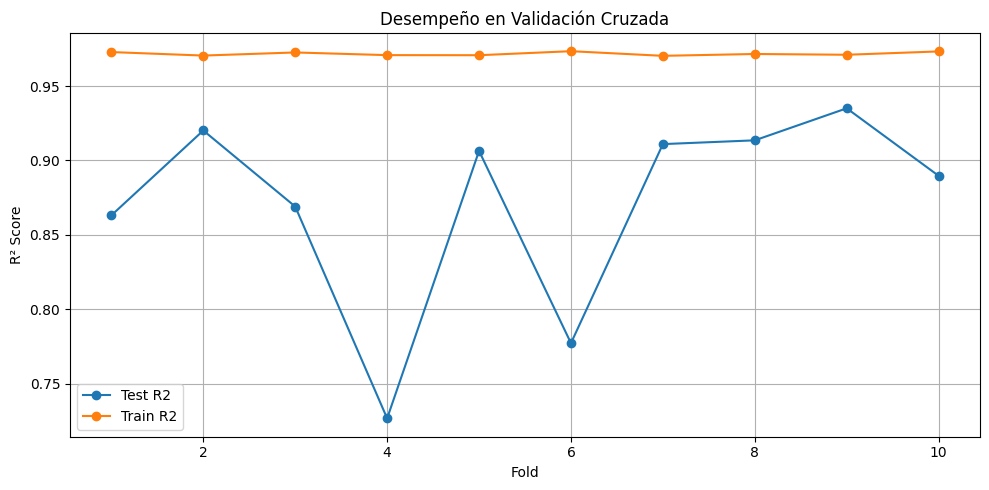

In [71]:
import matplotlib.pyplot as plt

# Excluir filas 'Mean' y 'Std'
fold_results = results_df.iloc[:10]  # O también results_df.iloc[:-2]

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), fold_results['Test R2'], 'o-', label='Test R2')
plt.plot(range(1, 11), fold_results['Train R2'], 'o-', label='Train R2')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('Desempeño en Validación Cruzada')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Entrenamiento del Modelo con el conjunto de entrenamiento completo

In [72]:
# Una vez observada la estabilidad del modelo entrenamos con todo el conjunto de entrenamiento
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7cd29866e790>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7cd2995a4050>)])),
                ('regressor', GradientBoostingRegressor(random_state=123))])

In [79]:
# Evaluar el conjunto de prueba (No confiables.)
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R²: {r2:.3f}")


RMSE: 26,777
MAE: 16,627
R²: 0.907


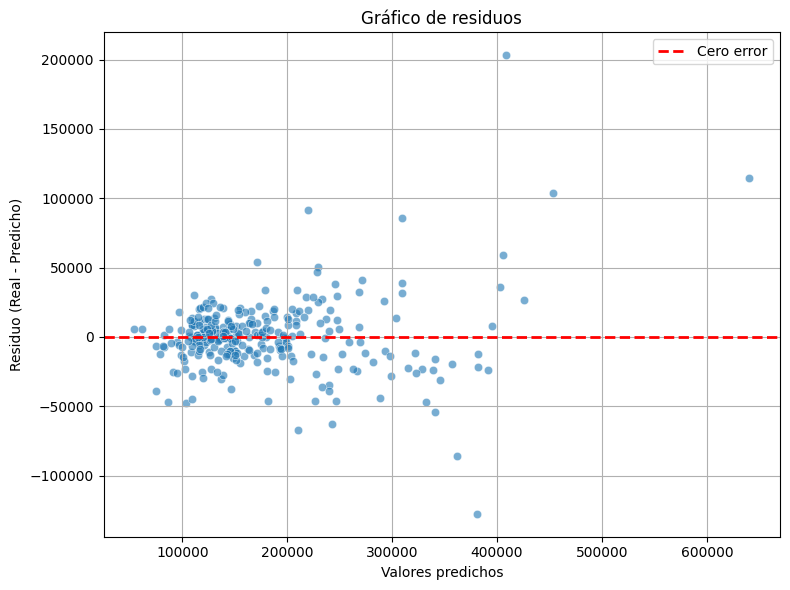

In [78]:
#Analisis de Residuos
# Calcular residuos
residuos = y_test - y_pred

# Gráfico de residuos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', lw=2, label='Cero error')
plt.xlabel('Valores predichos')
plt.ylabel('Residuo (Real - Predicho)')
plt.title('Gráfico de residuos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 5.- Optimizar Modelo 

In [80]:
#Procesamos Xtrain, para evitar Data Lakeage
X_processed = preprocessor.fit_transform(X_train)
#X_test_processed= preprocessor.fit_transform(X_test)

In [81]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 123,
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=123)
    mse_scores = []

    for train_idx, val_idx in kf.split(X_processed):
        X_tr, X_vl = X_processed[train_idx], X_processed[val_idx]
        y_tr, y_vl = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_vl, y_vl)],
            early_stopping_rounds=10,
            verbose=False
        )

        y_pred = model.predict(X_vl)
        mse_scores.append(mean_squared_error(y_vl, y_pred))

    return np.mean(mse_scores)


In [82]:
# 3. Optimización con Optuna (ahora direction='minimize')
study = optuna.create_study(
    direction='minimize',  # Minimizamos MSE
    sampler=TPESampler(seed=123)
)
study.optimize(objective, n_trials=50)  # 50 iteraciones

[I 2025-06-05 19:28:18,650] A new study created in memory with name: no-name-b555c841-35ca-44f0-92a5-815ff56aeb43
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit`

In [83]:
# 4. Resultados
print("Mejores hiperparámetros:", study.best_params)
print("Mejor MSE:", study.best_value)

Mejores hiperparámetros: {'n_estimators': 311, 'learning_rate': 0.053840960686833764, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.929421248390642, 'colsample_bytree': 0.8677436005089618, 'gamma': 2.2440192604979816, 'reg_alpha': 0.555215923181245, 'reg_lambda': 0.35468670008048364}
Mejor MSE: 719530575.1371396


In [84]:
# 5. Entrenar el modelo final con los mejores parámetros
best_model = XGBRegressor(**study.best_params)
best_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', best_model)
])

best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7cd29866e790>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <skle...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.053840960686833764, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=4, max_leaves=None,
                              min_child_weight=2, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=311, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [85]:
# Evaluar con el conjunto de prueba 
y_pred = best_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R²: {r2:.3f}")

RMSE: 24,407
MAE: 15,351
R²: 0.922


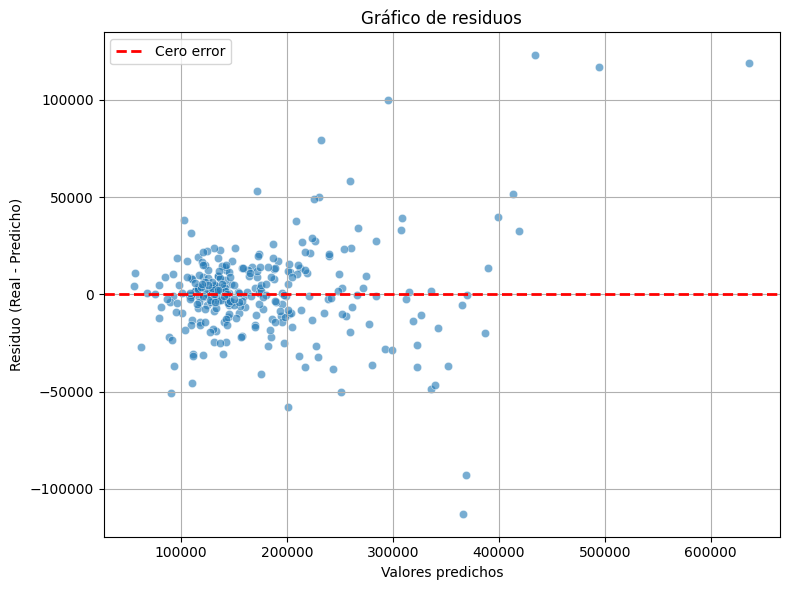

In [86]:
#Analisis de Residuos
# Calcular residuos
residuos = y_test - y_pred

# Gráfico de residuos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', lw=2, label='Cero error')
plt.xlabel('Valores predichos')
plt.ylabel('Residuo (Real - Predicho)')
plt.title('Gráfico de residuos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

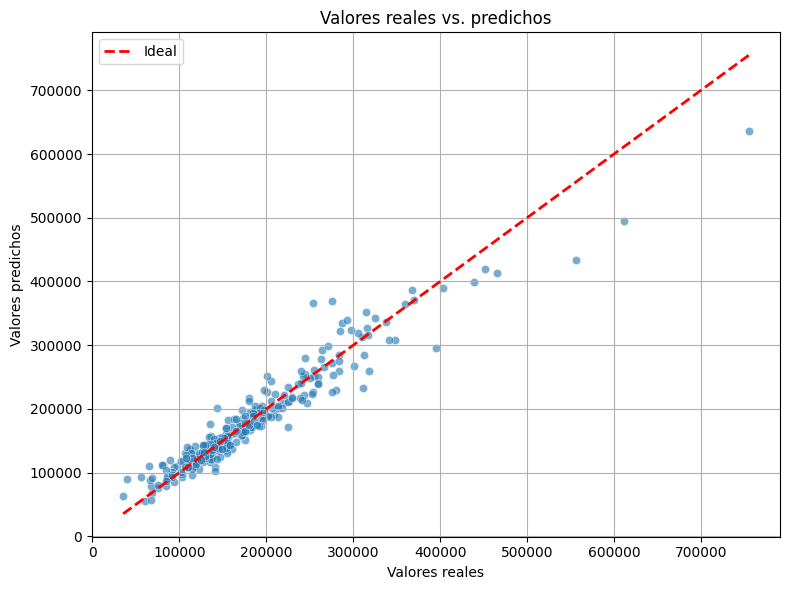

In [87]:
#Analisis de predichos y valores reales
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal')
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Valores reales vs. predichos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


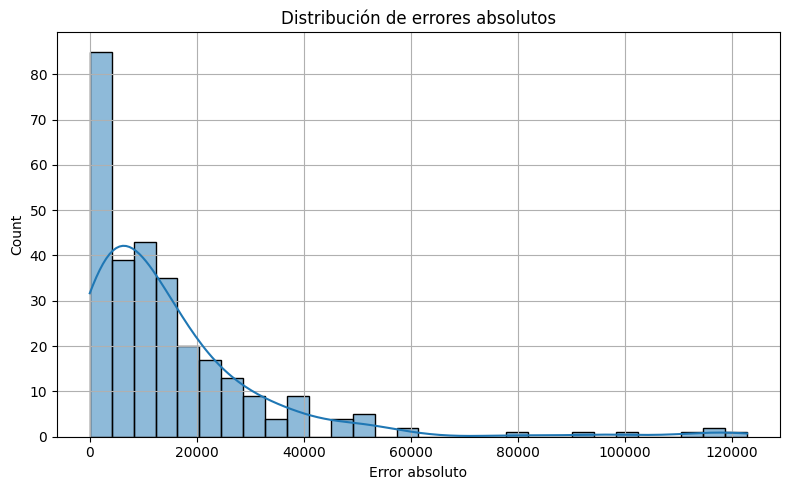

In [88]:
#Grafico de Distribucion de errores absolutos
errores = np.abs(y_test - y_pred)

plt.figure(figsize=(8, 5))
sns.histplot(errores, bins=30, kde=True)
plt.xlabel('Error absoluto')
plt.title('Distribución de errores absolutos')
plt.grid(True)
plt.tight_layout()
plt.show()

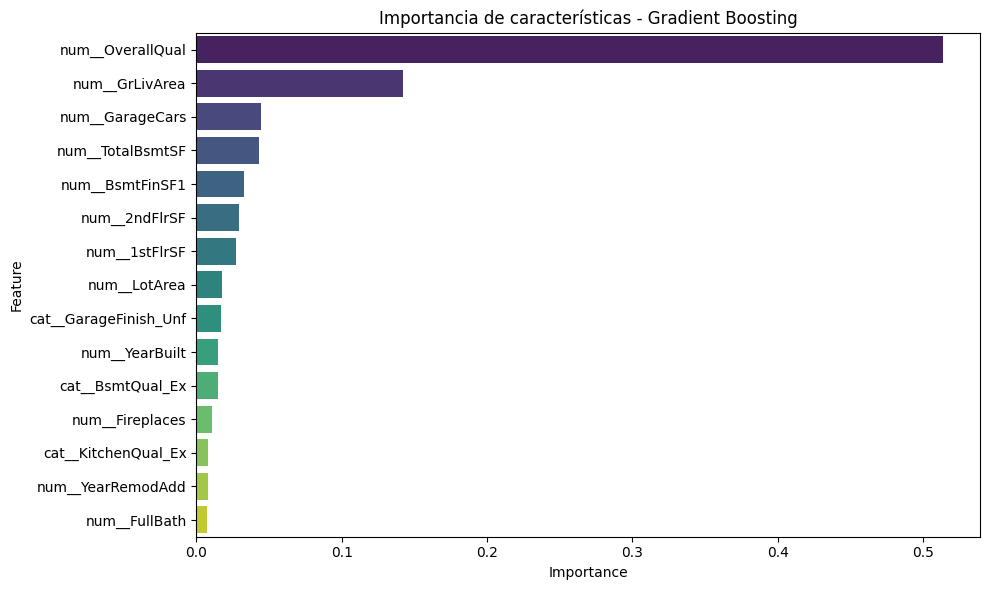

In [89]:
#Impoartancia Caracteristicas.

# Obtener importancias
importances = pipeline.named_steps['regressor'].feature_importances_
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

# Crear DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Importancia de características - Gradient Boosting')
plt.tight_layout()
plt.show()

## 6.-Guardar Modelo Para Uso Posterior

In [90]:
# guardar las columnas eliminadas junto con el modelo usando joblib (más recomendable)
joblib.dump({
    'modelo': best_pipeline,
    'columnas_eliminadas': list(cols_to_drop)
}, 'modelo_y_columnas.pkl')

['modelo_y_columnas.pkl']

## 6.- Importar modelo para predecir con el conjunto test.csv

In [91]:
# Cargar modelo y columnas eliminadas
data = joblib.load('modelo_y_columnas.pkl')
modelo = data['modelo']
cols_eliminadas = data['columnas_eliminadas']


In [92]:
# Cargar test
df_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
X_test = df_test.drop(['Id'], axis=1)
X_test = X_test.drop(columns=cols_eliminadas, errors='ignore')

In [93]:
# Predecir con el conjunto de prueba
y_pred = modelo.predict(X_test)

In [94]:
# Exportar para Kaggle
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': y_pred
})
submission.to_csv("submission.csv", index=False)

In [95]:
# Verificar que sea el formato que desea Kaggle
submission.head(5)

,Id,SalePrice
0,1461,125416.703125
1,1462,153125.578125
2,1463,180696.953125
3,1464,191361.234375
4,1465,193926.562500
